In [1]:
import pandas as pd
from E_Salary_Cities import read,rename_columns,merge,clean_positions
from E_Position_YearsOfExperience import clean_position,clean_senior_col,clean_years
from E_Age_CompanyType import plt_univariate_histogram
from E_Contract_Salary import clean_contract
import re
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\marye\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> State & Refine QS</h1></div>


What is the relationship between contract duration & salary? 

In [2]:
df20, df19, df18 = read()
rename_columns(df20,df19,df18)
common_cols = set(df20.columns).intersection(df19.columns)
print(common_cols)
df = merge([df20,df19],common_cols)
df.info()


{'Gender', 'Company size', 'Age', 'Your main technology / programming language', 'Main language at work', 'Company type', 'Сontract duration', 'Position', 'Years of experience', 'Number of vacation days', 'City', 'Salary', 'Seniority level'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Gender                                       2234 non-null   object 
 1   Company size                                 2212 non-null   object 
 2   Age                                          2108 non-null   float64
 3   Your main technology / programming language  2103 non-null   object 
 4   Main language at work                        2223 non-null   object 
 5   Company type                                 2188 non-null   object 
 6   Сontract duration                            2186 non-

d:\Study\4B\Data science\github\Data-Science-Project\Questions\E_Salary_Cities.py:41: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat(data_frames, ignore_index=True)[common_columns]


In [3]:
SALARY = 'Salary'
CONTRACT = 'Сontract duration'
print(df[[SALARY,CONTRACT]].isna().sum())
contract_salary = df[[CONTRACT,SALARY]].dropna()


Salary                1
Сontract duration    58
dtype: int64


Salary statistics

In [4]:
print(contract_salary.head(5))

    Сontract duration    Salary
0  Unlimited contract   80000.0
1  Unlimited contract   80000.0
2  Temporary contract  120000.0
3  Unlimited contract   54000.0
4  Unlimited contract   62000.0


Salaries are all in Euro, no need to unify the currency . we will use it directly

#### Just one missing value for the salary column, no need to impute.

In [5]:
print("There are",df[SALARY].isna().sum(), "missing salary/ies")

There are 1 missing salary/ies


## Exploring the salary statistics

In [6]:
# compute mean, median, and standard deviation of a column
mean_salary = contract_salary[SALARY].astype(float).mean()
median_salary = contract_salary[SALARY].astype(float).median()
std_salary = contract_salary[SALARY].astype(float).std()
max_salary = contract_salary[SALARY].astype(float).max()
min_salary = contract_salary[SALARY].astype(float).min()

# display the computed statistics
print('Mean salary: ', mean_salary)
print('Median salary: ', median_salary)
print('Standard deviation of salary: ', std_salary)
print('Max salary: ', max_salary)
print('Min salary: ', min_salary)


Mean salary:  300307.1538352403
Median salary:  70000.0
Standard deviation of salary:  10695071.571778344
Max salary:  500000000.0
Min salary:  6000.0


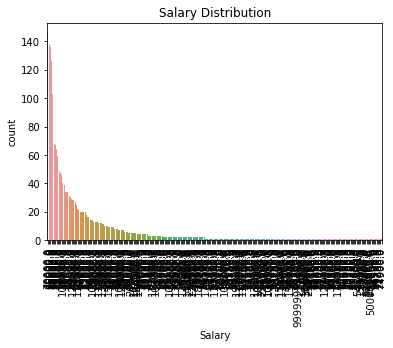

In [7]:
plt_univariate_histogram(df,SALARY)

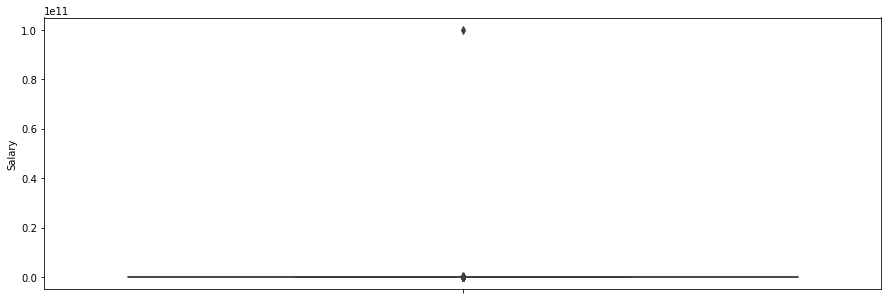

In [8]:
plt.figure(figsize=(15, 5))
sns.boxplot(y=SALARY, data=df)
plt.xticks(rotation=90)
plt.show()

1-Expectation :
I guess the mean of the annaual salary of an IT engineer in Germany is around 50-60k in euors as Google says so.

2-After collecting:
The data says that the mean of salaries is 4487k, but median is 70k 

3-Comparing Data and expectations:
the median is not much far from the expected mean, but the mean is much more larger than the expected.
As we know it, mean is sensitive to outliers .Let's remove outliers and double-check.

### There are outliers that needs removal

In [9]:
from E_Salary_Cities import remove_outliers
contract_salary = remove_outliers(df,SALARY)

In [10]:
contract_salary = contract_salary[contract_salary[SALARY] != 'nan']
contract_salary[SALARY] = contract_salary[SALARY].astype('float64')
contract_salary[SALARY] = contract_salary[SALARY].astype('int64')

#### Repeat the cycle 

In [11]:
mean_salary = contract_salary[SALARY].mean()
median_salary = contract_salary[SALARY].median()
std_salary = contract_salary[SALARY].std()
max_salary = contract_salary[SALARY].max()
min_salary = contract_salary[SALARY].min()

# display the computed statistics
print('Mean salary: ',mean_salary)
print('Median salary: ', median_salary)
print('Standard deviation of salary: ', std_salary)
print('Max salary: ', max_salary)
print('Min salary: ', min_salary)

Mean salary:  69135.70384615385
Median salary:  68375.0
Standard deviation of salary:  15808.153332636677
Max salary:  110000
Min salary:  30000


Now Expectation meets the reality,
As expected the outliers affected the mean heavly, so after removing them we can see that the mean and median are close to each other and to what we expected .

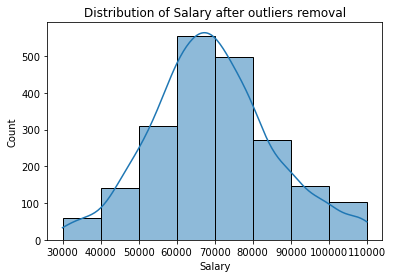

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data=contract_salary[SALARY], kde=True, binwidth=10000)
plt.xlabel('Salary')
plt.ylabel('Count')
plt.title('Distribution of Salary after outliers removal')
plt.show()

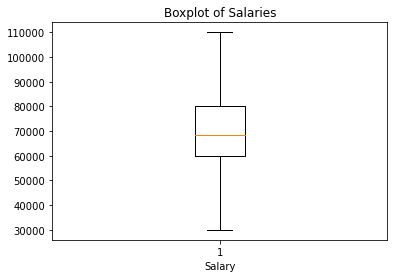

In [13]:
# plot boxplot
plt.boxplot(contract_salary[SALARY])
plt.xlabel(SALARY)
plt.title('Boxplot of Salaries')
plt.show()

## Contract duration

#### To know the different categories of duration:

In [14]:
unique_duration = contract_salary[CONTRACT].unique()
print("There is",len(unique_duration))
print("The categories are:",unique_duration)

There is 8
The categories are: ['Unlimited contract' 'Temporary contract' nan 'unlimited' '6 months'
 'more than 1 year' '1 year' '3 months']


There are missing (nan) values that need to be processed

In [15]:
null = contract_salary[CONTRACT].isna().sum()
print("There are ",null,"missing values in duration")

There are  38 missing values in duration


#### For the missing values, i think it's proper to remove these rows as its a personal choice that we can't impute.

In [16]:
contract_salary = contract_salary[~contract_salary[CONTRACT].isna()]
print(contract_salary[CONTRACT].unique())

['Unlimited contract' 'Temporary contract' 'unlimited' '6 months'
 'more than 1 year' '1 year' '3 months']


Apply data cleaning to unify similar (mis-spelled) categories 

In [17]:
contract_salary= clean_contract(contract_salary)
unique_duration = contract_salary[CONTRACT].unique()
print("There is",len(unique_duration))
print("The categories are:",unique_duration)

There is 6
The categories are: ['unlimited' 'temporary contract' '6 months' 'more than 1 year' '1 year'
 '3 months']


In [19]:
mode_duration = contract_salary[CONTRACT].mode()
# display the computed statistics
print('Mode duration: ',mode_duration)

Mode duration:  0    unlimited
Name: Сontract duration, dtype: object


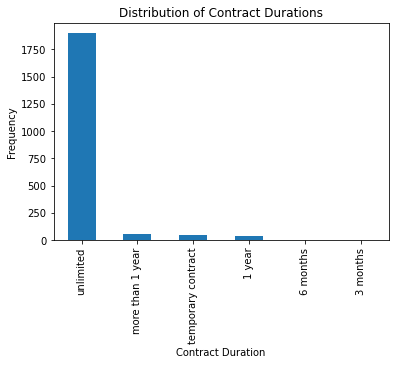

unlimited             1900
more than 1 year        56
temporary contract      45
1 year                  34
6 months                 6
3 months                 1
Name: Сontract duration, dtype: int64


In [20]:
# count the frequency of each category
duration_counts = contract_salary[CONTRACT].value_counts()
# plot bar chart
duration_counts.plot(kind='bar')
plt.xlabel('Contract Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Contract Durations')
plt.show()
category_counts = contract_salary[CONTRACT].value_counts(normalize=False)

print(category_counts)

1-Expectation :
After searching i found that,the indefinite (unlimited) contract is the standard contract type.

2-After collecting:
The data says that most frequent category is the unlimited . 

3-Comparing Data and expectations:
We found what we are expecting.

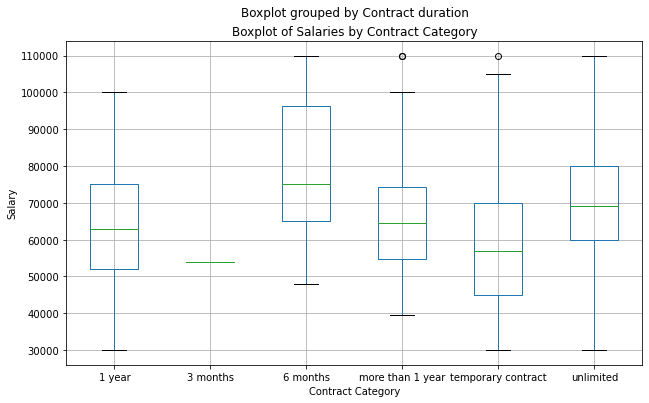

In [21]:
# plot boxplots by contract category
contract_salary.boxplot(column=SALARY, by=CONTRACT, figsize=(10,6))
plt.xlabel('Contract Category')
plt.ylabel('Salary')
plt.title('Boxplot of Salaries by Contract Category')
plt.show()

#### Expectations : 
In general, longer contract durations may be associated with higher salaries, as they can provide more job security and stability for employees . However, this relationship can vary depending on factors such as job role, industry sector, and company size. For example, some companies may offer higher salaries for shorter contract durations to attract top talent or fill specific project needs

### Collecting information
The graph shows that there is variation in the average salary in different contract categories.
For example, 6 months category has the highest average of salaries.
Average salaries in the unlimited category is close to the mean & median (expected as it's the
majority).

### Comparing Data and Expectations
I believe Expectations match collected information

In [23]:
# calculate mean salary for each contract category
category_means = contract_salary.groupby(CONTRACT)[SALARY].mean()
print(category_means)

Сontract duration
1 year                63741.176471
3 months              54000.000000
6 months              78833.333333
more than 1 year      65407.142857
temporary contract    59282.222222
unlimited             69420.981053
Name: Salary, dtype: float64


### Is there a Relationship between Contract duration and salary ?

In [24]:
from scipy.stats import kruskal
# group salary by contract duration
groups = []
for name, group in contract_salary.groupby(CONTRACT):
    groups.append(group[SALARY])

# perform Kruskal-Wallis H test
stat, p = kruskal(*groups)

# print test results
print('Kruskal-Wallis H test')
print('Test statistic:', stat)
print('p-value:', p)

Kruskal-Wallis H test
Test statistic: 27.608562189681496
p-value: 4.3405931086896265e-05


The Kruskal-Wallis H test is a non-parametric statistical test that compares the median values of the independent groups to determine if there is a significant difference between them. Specifically, it tests the null hypothesis that the median values of all groups are equal against the alternative hypothesis that at least one group has a different median value.

#### Expectations :
I expect from the graph and other search i did that, the salaries varies in different contract durations based on different point of views

#### Collected Data:
The hypothesis test kruskal resulted in a p value that is smaller enough than 0.05 to conclude that there is enough evidence to suggest a significant difference in salary among the contract duration categories.

### Comparing Data and Expectations
Collected data meets our expectation and we can say that there is some relation between the contract duration and salary, indeed it's not the only affecting factor.However , on average it has some effect

# Interpretaion
Based on the results of the Kruskal-Wallis H test with a p-value of 4.3405931086896265e-05, we can conclude that there is a statistically significant difference in salary between at least two of the categories of contract duration. This suggests that contract duration may be a factor that influences salary for IT engineers in Germany.

However, the Kruskal-Wallis H test does not identify which specific groups have significantly different median salaries. To determine which groups are significantly different, we should perform post-hoc tests such as the Mann-Whitney U test or Dunn's test.

It's important to note that statistical significance does not necessarily imply practical significance. Therefore, it's important to interpret the results of statistical tests in the context of the data and consider the practical implications of the findings. Additionally, correlation does not necessarily imply causation, so it's important to consider other factors that may influence salary for IT engineers in Germany, such as experience, education, skills, job role, and company size.

# Business value
Recruitment and Hiring: Understanding the relationship between contract duration and salary can help businesses attract and retain top talent by offering competitive compensation packages that align with industry standards. For example, if there is a positive correlation between contract duration and salary, businesses may need to adjust their salary offers for temporary or short-term contract positions to remain competitive.
 In a positive correlation between contract duration and salary, it's possible that shorter contract durations may be associated with lower salaries. In this case, businesses may need to adjust their salary offers for temporary or short-term contract positions to remain competitive.

One reason to do this is to attract top talent in a competitive job market. Even for short-term or temporary positions, businesses may need to offer competitive salaries to attract qualified candidates who have multiple job offers or options. Offering a lower salary for short-term positions may make the position less attractive to potential candidates, which can make it harder for the business to fill the position and complete the project on time and within budget.

Additionally, offering fair and competitive compensation packages can help businesses build a positive reputation as an employer of choice. This can lead to higher employee satisfaction, better retention rates, and increased productivity and profitability in the long run.

Therefore, even if shorter contract durations are associated with lower salaries, businesses may need to consider offering competitive salaries to remain competitive in the job market and attract top talent. Ultimately, the decision on how to adjust salary offers for different contract durations should be based on a thorough analysis of the data and the specific context of the business and industry.